# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# Intstall PyTorch and download data
#!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2019-04-24 14:19:38--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  15.7MB/s    in 14s     

2019-04-24 14:19:53 (12.3 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2019-04-24 14:19:53--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  17.3MB/s    in 3.9s    

2019-04-24 14:19:57 (15.8 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2019-04-24 14:19:57--
Total wall clock time: 19s
Downloaded: 2 files, 235M in

In [0]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler
import copy

from torchvision import transforms

In [0]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [0]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [0]:
batch_size = 64

data_size = data_train.data.shape[0]
#print(data_size)
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [0]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [0]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler='None'):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        train_loader, val_loader = loaders()
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy, val_loss = compute_accuracy(model, val_loader, loss)
        
        if scheduler != 'None':
            if type(scheduler) is torch.optim.lr_scheduler.ReduceLROnPlateau:   
                scheduler.step(val_loss) 
            else :
                scheduler.step() 
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader, loss="whatever"):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    correct_samples = 0
    total_samples = 0

    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: torch doesn't have a dedicated argmax function,
    #       but you can use torch.max instead (see the documentation).
    for i_step, (x, y) in enumerate(loader):
        
        x, y = x.to(device), y.to(device) #, non_blocking=True
        
        prediction = model(x)
        indices = torch.argmax(prediction, 1)
             
        correct_samples += (indices == y).sum().item()
        total_samples += y.size(0)
    
    if loss == 'none':
        return correct_samples/total_samples
    
    return correct_samples/total_samples, loss(prediction, y)



In [19]:
from time import time
start = time()
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)
end = time()
print('\n',end - start)

Average loss: 2.352329, Train accuracy: 0.070880, Val accuracy: 0.069756
Average loss: 2.352577, Train accuracy: 0.071238, Val accuracy: 0.069279
Average loss: 2.352371, Train accuracy: 0.069617, Val accuracy: 0.070985
Average loss: 2.352779, Train accuracy: 0.069447, Val accuracy: 0.070439
Average loss: 2.353190, Train accuracy: 0.068901, Val accuracy: 0.073852

 329.4894495010376


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [12]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)
batch_size = 64

data_size = data_aug_train.data.shape[0]
print(data_size)

73257


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

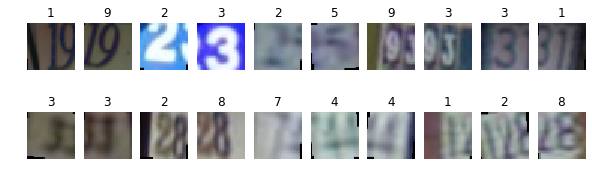

In [13]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs1 = transforms.Compose([
    transforms.ColorJitter(hue=.10, saturation=.20),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.RandomResizedCrop(32,scale=(0.8, 0.99))
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs1
                      )

plt.figure(figsize=(10, 3))

N = 20
for i, (x, y) in enumerate(data_aug_vis):
    if i == N:
        break
    plt.subplot(2, 10, i+1).set_title(y)
    #print(y)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [0]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    #transforms.RandomResizedCrop(32,scale=(0.8, 0.99)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [20]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 2.352243, Train accuracy: 0.069549, Val accuracy: 0.071667
Average loss: 2.352387, Train accuracy: 0.068850, Val accuracy: 0.074739
Average loss: 2.351719, Train accuracy: 0.069600, Val accuracy: 0.069074
Average loss: 2.352742, Train accuracy: 0.068542, Val accuracy: 0.073101
Average loss: 2.352299, Train accuracy: 0.069822, Val accuracy: 0.070712


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [0]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
        nn.Conv2d(3, 6, 5, padding=0),
        nn.AvgPool2d(2,2),
        nn.Tanh(),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.AvgPool2d(2,2),
        nn.Tanh(),
        nn.Conv2d(16, 120, 5, padding=0), 
        nn.Tanh(),
        Flattener(),
        nn.Linear(120, 84),
        nn.Tanh(),
        nn.Linear(84, 10),
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [22]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 2.102021, Train accuracy: 0.258625, Val accuracy: 0.564467
Average loss: 0.993891, Train accuracy: 0.687592, Val accuracy: 0.787660
Average loss: 0.709872, Train accuracy: 0.779562, Val accuracy: 0.829090
Average loss: 0.613960, Train accuracy: 0.809746, Val accuracy: 0.842195
Average loss: 0.558477, Train accuracy: 0.825581, Val accuracy: 0.823903
Average loss: 0.527694, Train accuracy: 0.836484, Val accuracy: 0.870043
Average loss: 0.499690, Train accuracy: 0.843753, Val accuracy: 0.866494
Average loss: 0.480681, Train accuracy: 0.851176, Val accuracy: 0.880622
Average loss: 0.467941, Train accuracy: 0.854435, Val accuracy: 0.878575
Average loss: 0.453458, Train accuracy: 0.857574, Val accuracy: 0.889154


# Подбор гиперпараметров

In [0]:
def loaders(bs=64, valsplit=.2): #returns data loaders, val loader loads not augmented data
  data_train = dset.SVHN('./', split='train',
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(mean=[0.43,0.44,0.47],
                                                 std=[0.20,0.20,0.20])                           
                         ])
                        )
  '''data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(mean=[0.43,0.44,0.47],
                                                 std=[0.20,0.20,0.20])                           
                         ]))'''
  tfs = transforms.Compose([
    
    transforms.ColorJitter(hue=.30, saturation=.30),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.RandomResizedCrop(32,scale=(0.9, 0.99)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])
  data_aug_train = dset.SVHN('./', split='train',
                         transform=tfs
                        )

  batch_size = bs

  data_size = data_aug_train.data.shape[0]
  assert data_size == data_train.data.shape[0]
  validation_split = valsplit
  split = int(np.floor(validation_split * data_size))
  indices = list(range(data_size))
  np.random.shuffle(indices)

  train_indices, val_indices = indices[split:], indices[:split]

  train_sampler = SubsetRandomSampler(train_indices)
  val_sampler = SubsetRandomSampler(val_indices)

  train_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                             sampler=train_sampler)
  val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                           sampler=val_sampler)
  #test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
  return train_loader, val_loader

In [0]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 5, 10, 15, 20, 50]
reg = [1e-3, 1e-4, 1e-5, 1e-7]

runs = 8
lrs = [ 1 * 10**(-4*np.random.rand()) for i in range(runs)]
rss = [ 1 * 10**(-3 -4*np.random.rand()) for i in range(runs)]

epoch_num = 6
batch_size = 32
# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 
#run_record[Hyperparams(lr,anneal,rs)] = RunResult(model,train_history, val_history, final_val_accuracy)
train_loader, val_loader = loaders(bs = batch_size)
# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!
anneal = 0.99
momentum = 0.85

for i in range(runs):
  lr = lrs[i]
  rs = rss[i]
  
  lenet_model = nn.Sequential(
          nn.Conv2d(3, 6, 5, padding=0),
          nn.AvgPool2d(2,2),
          nn.Tanh(),
          nn.Conv2d(6, 16, 5, padding=0),
          nn.AvgPool2d(2,2),
          nn.Tanh(),
          nn.Conv2d(16, 120, 5, padding=0), 
          nn.Tanh(),
          Flattener(),
          nn.Linear(120, 84),
          nn.Tanh(),
          nn.Linear(84, 10),
            )

  lenet_model.type(torch.cuda.FloatTensor)
  lenet_model.to(device)

  loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
  optimizer = optim.SGD(lenet_model.parameters(), lr=lr, weight_decay=rs, momentum=momentum, nesterov=True)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=anneal)
  #training here
  
  loss_history, train_history, val_history = train_model(lenet_model, train_loader, val_loader, loss, optimizer, epoch_num, scheduler=scheduler)
  #saving results
  model = copy.deepcopy(lenet_model)
  run_record[Hyperparams(lr,anneal,rs)] = RunResult(model,list(train_history), list(val_history),val_history[-1])

Average loss: 2.216281, Train accuracy: 0.211446, Val accuracy: 0.268992
Average loss: 1.407876, Train accuracy: 0.544688, Val accuracy: 0.752850
Average loss: 0.669139, Train accuracy: 0.795601, Val accuracy: 0.837759
Average loss: 0.559230, Train accuracy: 0.828994, Val accuracy: 0.845540
Average loss: 0.506164, Train accuracy: 0.846364, Val accuracy: 0.867245
Average loss: 0.473063, Train accuracy: 0.855766, Val accuracy: 0.866835
Average loss: 1.254359, Train accuracy: 0.577739, Val accuracy: 0.743908
Average loss: 0.658302, Train accuracy: 0.792223, Val accuracy: 0.815576
Average loss: 0.577067, Train accuracy: 0.819080, Val accuracy: 0.828135
Average loss: 0.545427, Train accuracy: 0.828942, Val accuracy: 0.824790
Average loss: 0.522668, Train accuracy: 0.834744, Val accuracy: 0.843355
Average loss: 0.504112, Train accuracy: 0.843037, Val accuracy: 0.844038
Average loss: 1.202561, Train accuracy: 0.607566, Val accuracy: 0.771756
Average loss: 0.793187, Train accuracy: 0.753558, V

In [0]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.87, best hyperparams: Hyperparams(learning_rate=0.00520559311209558, anneal_epochs=0.99, reg=1.6847871797632812e-07)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [0]:
best_model = None

In [0]:
depth1 = 50
depth2 = 260
batch_size = 64
lr=1e-3
rs=1e-5
momentum = 0.85
epoches = 10
annealing = .95

model1 = nn.Sequential(
      nn.Conv2d(3, 3, kernel_size=(1,3), padding=0),
      nn.Conv2d(3, 3, kernel_size=(3,1), padding=0),
      nn.Conv2d(3, 3, kernel_size=(1,3), padding=0),
      nn.Conv2d(3, 3, kernel_size=(3,1), padding=0),
      nn.Conv2d(3, depth1, kernel_size=1, padding=0), #conv(3,depth1,5,0) -- result 28x28xdepth1
      nn.MaxPool2d(2), #14x14
      nn.RReLU(.0002, 0.01, inplace=True),
      nn.BatchNorm2d(depth1),
      nn.Conv2d(depth1, depth1, kernel_size=(1,3), padding=0),
      nn.Conv2d(depth1, depth2, kernel_size=(3,1), padding=0),
      nn.MaxPool2d(2), #6x6
      nn.RReLU(.0002, 0.01, inplace=True),
      nn.BatchNorm2d(depth2),
      Flattener(),
      nn.Linear(6*6*depth2, 500),
      nn.RReLU(.0001, 0.03, inplace=True), 
      nn.BatchNorm1d(500),          
      nn.Linear(500, 10),
            )

model1.type(torch.cuda.FloatTensor)
model1.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(model1.parameters(), lr=lr, weight_decay=rs, momentum=momentum, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2,
                                                      verbose=True, threshold=0.0002) 

train_loader, val_loader = loaders(bs = batch_size) #может попробовать занести лоадер в функцию тренировки и каждую эпоху новую аугментацию делать
loss_history, train_history, val_history = train_model(model1, train_loader, val_loader, loss, optimizer, epoches, scheduler=scheduler)

Average loss: 0.949531, Train accuracy: 0.718766, Val accuracy: 0.856733
Average loss: 0.502076, Train accuracy: 0.853684, Val accuracy: 0.886492
Average loss: 0.424627, Train accuracy: 0.875303, Val accuracy: 0.900280
Average loss: 0.378002, Train accuracy: 0.890745, Val accuracy: 0.908266
Average loss: 0.339118, Train accuracy: 0.901751, Val accuracy: 0.917071
Epoch     5: reducing learning rate of group 0 to 5.0000e-04.
Average loss: 0.315459, Train accuracy: 0.908917, Val accuracy: 0.924852
Average loss: 0.277671, Train accuracy: 0.920452, Val accuracy: 0.935704
Average loss: 0.264096, Train accuracy: 0.926049, Val accuracy: 0.940277
Average loss: 0.255488, Train accuracy: 0.928267, Val accuracy: 0.944918
Average loss: 0.242121, Train accuracy: 0.932515, Val accuracy: 0.949969


In [24]:
depth1 = 40
depth11 = 100
depth2 = 200
depth3 = 500

hll = 2000
lr=1e-3
rs=1e-5
momentum = 0.875
epoches = 15
model2 = nn.Sequential(
      nn.Conv2d(3, depth1, kernel_size=5, padding=2),
      nn.RReLU(.0002, 0.01, inplace=True),
      nn.BatchNorm2d(depth1),
      nn.Conv2d(depth1, depth11, kernel_size=3, padding=1),
      nn.MaxPool2d(2), #16x16
      nn.RReLU(.0002, 0.01, inplace=True),
      nn.BatchNorm2d(depth11),
      nn.Conv2d(depth11, depth2, kernel_size=3, padding=1),      
      nn.MaxPool2d(2), #8x8
      nn.RReLU(.0002, 0.01, inplace=True),
      nn.BatchNorm2d(depth2),
      nn.Conv2d(depth2, depth3, kernel_size=3, padding=1),      
      nn.MaxPool2d(2), #4x4
      nn.RReLU(.0002, 0.01, inplace=True),
      nn.BatchNorm2d(depth3),
      Flattener(),
      nn.Linear(4*4*depth3, hll),
      nn.RReLU(.0001, 0.03, inplace=True), 
      nn.BatchNorm1d(hll),          
      nn.Linear(hll, 10),
            )

model2.type(torch.cuda.FloatTensor)
model2.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(model2.parameters(), lr=lr, weight_decay=rs, momentum=momentum, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.6, patience=2,
                                                      verbose=True, threshold=0.0002) 


loss_history2, train_history2, val_history2 = train_model(model2, train_loader, val_loader, loss, optimizer, epoches, scheduler=scheduler)

Average loss: 0.700163, Train accuracy: 0.782104, Val accuracy: 0.897481
Average loss: 0.383031, Train accuracy: 0.886718, Val accuracy: 0.921029
Average loss: 0.310928, Train accuracy: 0.908712, Val accuracy: 0.935977
Average loss: 0.271332, Train accuracy: 0.920674, Val accuracy: 0.939731
Average loss: 0.242729, Train accuracy: 0.930724, Val accuracy: 0.948399
Average loss: 0.219880, Train accuracy: 0.937259, Val accuracy: 0.957204
Average loss: 0.200384, Train accuracy: 0.943845, Val accuracy: 0.961914
Epoch     7: reducing learning rate of group 0 to 6.0000e-04.
Average loss: 0.183625, Train accuracy: 0.947940, Val accuracy: 0.964235
Average loss: 0.156691, Train accuracy: 0.956353, Val accuracy: 0.974336
Epoch    10: reducing learning rate of group 0 to 3.6000e-04.
Average loss: 0.135334, Train accuracy: 0.962615, Val accuracy: 0.980684
Average loss: 0.120039, Train accuracy: 0.967461, Val accuracy: 0.982868
Average loss: 0.113055, Train accuracy: 0.970396, Val accuracy: 0.986895


In [30]:
optimizer = torch.optim.Adam(nn_model.parameters(), lr=lr/3, weight_decay=rs/6, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.4, patience=2,
                                                      verbose=True, threshold=0.002)    

loss_history1, train_history1, val_history1 = train_model(model2, train_loader, val_loader, loss, optimizer, epoches, scheduler=scheduler)

loss_history2.extend(loss_history1) 
train_history2.extend(train_history1)
val_history2.extend(val_history1)

Average loss: 0.095073, Train accuracy: 0.975566, Val accuracy: 0.992219
Average loss: 0.092381, Train accuracy: 0.976470, Val accuracy: 0.992355
Average loss: 0.094194, Train accuracy: 0.975702, Val accuracy: 0.992492
Average loss: 0.093648, Train accuracy: 0.975634, Val accuracy: 0.991263
Average loss: 0.092981, Train accuracy: 0.976743, Val accuracy: 0.991878
Average loss: 0.093683, Train accuracy: 0.975446, Val accuracy: 0.992355
Epoch     6: reducing learning rate of group 0 to 1.3333e-04.
Average loss: 0.093270, Train accuracy: 0.976214, Val accuracy: 0.990990
Average loss: 0.094469, Train accuracy: 0.975924, Val accuracy: 0.992970
Average loss: 0.094959, Train accuracy: 0.975173, Val accuracy: 0.991673
Average loss: 0.093741, Train accuracy: 0.976385, Val accuracy: 0.992014
Average loss: 0.093347, Train accuracy: 0.976453, Val accuracy: 0.991263
Epoch    11: reducing learning rate of group 0 to 5.3333e-05.
Average loss: 0.093148, Train accuracy: 0.976709, Val accuracy: 0.991878


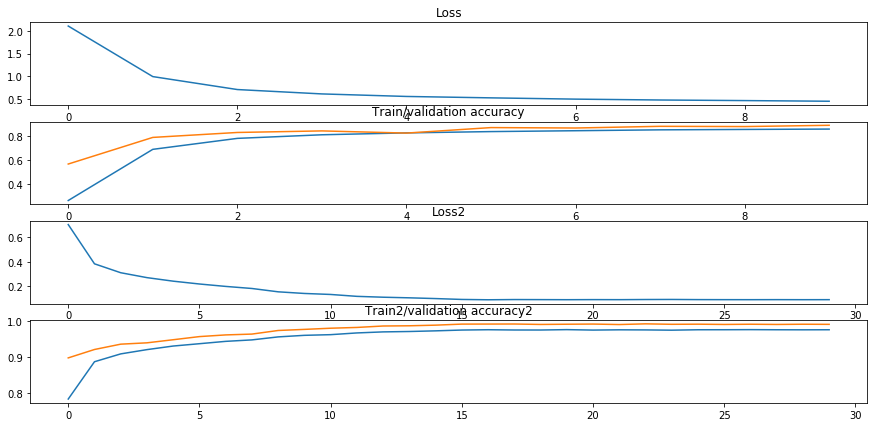

In [31]:
plt.figure(figsize=(15, 7))
plt.subplot(411)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(412)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

plt.subplot(413)
plt.title("Loss2")
plt.plot(loss_history2)
plt.subplot(414)
plt.title("Train2/validation accuracy2")
plt.plot(train_history2)
plt.plot(val_history2)

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [32]:
# TODO Write the code to compute accuracy on test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
#final_test_accuracy1 = compute_accuracy(model1, test_loader, loss = 'none')
final_test_accuracy2 = compute_accuracy(model2, test_loader, loss='none')
#print("Final test accuracy1 - ", final_test_accuracy1, "\n Final test accuracy2 - ", final_test_accuracy2)
print(" Final test accuracy - ", final_test_accuracy2)

 Final test accuracy -  0.9441456668715427
